In [105]:
%load_ext autoreload
%autoreload 2
import sys
if ".." not in sys.path:
    sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import asdict

from products.vanilla_option import VanillaOption
from models.model_params import LewisParams, MCParams, HestonParams, FractionalVolterraHestonParams
from models.heston import Heston
from models.fractional_volterra_heston import FractionalVolterraHeston
from utility.utility import from_delta_call_to_strike

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Fractional Volterra Heston Model

\begin{align*}
	dS_t &= S_t \sqrt{V_t} dW_t, \quad S_0=1,\\
	V_t &= V_0 + \int_0^t   K_{\epsilon}^H(t-s) \left(  \lambda(\theta - V_s) ds +  \nu  \sqrt{V_s} dB_s \right),
\end{align*}
with $K_{\epsilon}^H(t) = {{(t +\epsilon)}^{H-1/2}}$

### Pricing via characteristic function

The characteristic function in the Volterra model is given by
$$
\mathbb{E}\left[e^{u\log(S_T / S_0)}\right] = \exp\left\{\int_0^T F(\psi)(T - s)g_0(s)\, ds \right\},
$$
where
$$
g_0(t) = V_0 + \int_0^t K_\epsilon(t-s)\lambda\theta\, ds = V_0 + \dfrac{\lambda\theta}{\Gamma\left(H + \frac32 \right)}\left[(t + \epsilon)^{H+\frac12} - \epsilon^{H + \frac12}\right].
$$
and $\psi$ is a solution to the Volterra Riccati equation:
$$
\psi(t) =  \int_0^t K_\epsilon(t - s)F(\psi(s))\, ds,
$$
with
$$
F(\psi) = \dfrac12(u^2 - u) + (u\rho\nu - \lambda)\psi + \dfrac{\nu^2}{2}\psi^2.
$$
For a fixed T, the function $\psi$ is calculated on the uniform grid $\{t_k\}_{k=0}^{N}$ with step $\Delta$ by the fractional Adams method (described below), and the integral in the characteristic function is approximated according to the trapezoidal rule. 

## Adams scheme
We adapt the Adams scheme described in the article "The characteristic function of rough Heston models" for the rough Riccati equation ($\epsilon = 0$) for the case of shifted kernel.

Given the function $\psi$ on $\{t_j\}_{j=0}^k$ (initially $\psi(0) = 0$), we aim to compute $\psi(t_{k+1})$. The following predictor-corrector scheme is used:
$$
\psi^P(t_{k+1}) = \sum_{j=0}^k b_{j, k+1}F(\psi(t_j)), \\
\psi(t_{k+1}) = \sum_{j=0}^k a_{j, k+1}F(\psi(t_j)) + a_{k+1, k+1}F(\psi^P(t_{k+1})).
$$
Here the expression for the predictor comes from the rectangular approximation of the integral in the Riccati equation, and the final formula is a result of the trapezoidal rule applied to this integral. The coefficients for the shifted fractional kernel are given by
$$
b_{j, k+1} = \dfrac{1}{\Gamma\left(H+\frac32\right)}\left[(t_{k+1} - t_j + \epsilon)^{H+\frac12} - (t_{k+1} - t_{j+1} + \epsilon)^{H+\frac12}\right], \quad j = 0, \ldots, k, \\
a_{0, k+1} = \dfrac{1}{\Delta \Gamma\left(H+\frac52\right)}\left[ \Delta\left(H + \dfrac32\right)(t_{k+1} + \epsilon)^{H+\frac12}  + (t_{k+1} - t_1 + \epsilon)^{H + \frac32} - (t_{k+1} + \epsilon)^{H + \frac32} \right], \\
a_{j, k+1} = \dfrac{1}{\Delta \Gamma\left(H+\frac52\right)}\left[(t_{k+1} - t_{j - 1} + \epsilon)^{H+\frac32}  + (t_{k+1} - t_{j+1} + \epsilon)^{H + \frac32} - 2(t_{k+1} - t_j + \epsilon)^{H + \frac32} \right], \quad j = 1, \ldots, k, \\
a_{k+1, k+1} = \dfrac{1}{\Delta \Gamma\left(H+\frac52\right)}\left[ -\Delta\left(H + \dfrac32\right)\epsilon^{H+\frac12}  + (\Delta + \epsilon)^{H + \frac32} - \epsilon^{H + \frac32} \right].
$$

In [106]:
heston_params = HestonParams(V0=0.05, theta=0.06, lam=2, nu=0.4, rho=-0.3)
model_params = FractionalVolterraHestonParams(V0=0.05, theta=0.06, lam=2, nu=0.4, rho=-0.3, H=0.5, eps=0)

model_heston = Heston(**asdict(heston_params))
model = FractionalVolterraHeston(**asdict(model_params))
model.compile()

In [107]:
T = 0.5
F0 = 100

K = from_delta_call_to_strike(deltas = 1 - np.linspace(0.1, 0.9, 50), F0=F0, sigma=0.2, ttm=T)
k = np.log(K / F0)

option_call = VanillaOption(T=T, K=K, flag="call")

## Sanity check

In [108]:
%%time
smile_volterra = option_call.get_price(model=model, method="lewis", F0=F0, is_vol_surface=True, 
                                 pricing_params=LewisParams(cf_timestep=0.001, N_points=25))

smile_heston = option_call.get_price(model=model_heston, method="lewis", F0=F0, is_vol_surface=True, 
                                     pricing_params=LewisParams(cf_timestep=0.001, N_points=25))

Wall time: 3.22 s


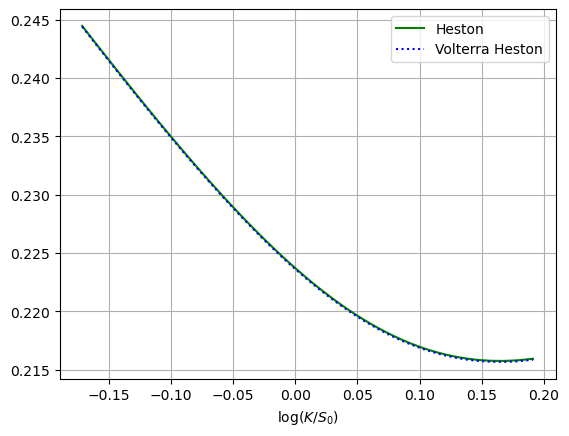

In [109]:
fix, ax = plt.subplots()

ax.plot(k, smile_heston, "g", label="Heston")
ax.plot(k, smile_volterra, "b:", label="Volterra Heston")

ax.legend()
ax.grid()
ax.set_xlabel(r"$\log(K / S_0)$")

plt.show()

### And now, really rough model

In [110]:
model_params = FractionalVolterraHestonParams(V0=0.05, theta=0.06, lam=2, nu=0.4, rho=-0.3, H=0.2, eps=0)

model = FractionalVolterraHeston(**asdict(model_params))
model.compile()

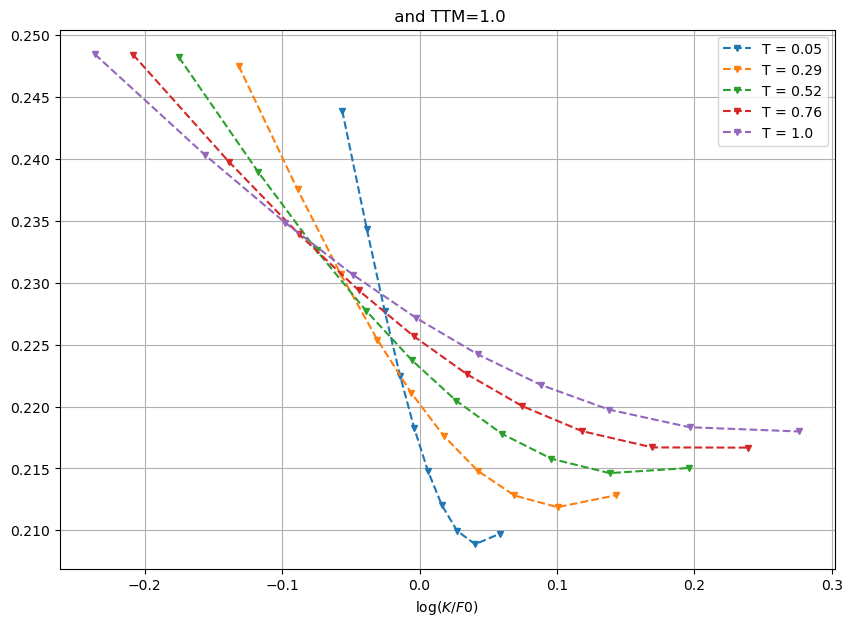

In [111]:
fig, ax = plt.subplots(figsize=(10, 7))

T_grid = np.linspace(0.05, 1, 5)
K_arr = np.array([from_delta_call_to_strike(deltas = 1 - np.linspace(0.1, 0.9, 10), F0=F0, sigma=0.2, ttm=T) for T in T_grid])
option_call_surf = VanillaOption(T=T_grid, K=K_arr, flag="call")


prices_surf = option_call_surf.get_price(model=model, method="lewis", F0=F0, is_vol_surface=False, 
                                         pricing_params=LewisParams(cf_timestep=0.001, N_points=25))
option_call_surf.plot_smiles(option_prices_model=prices_surf, F0=100, ax=ax)


In [112]:
%%time
prices_surf = option_call_surf.get_price(model=model, method="lewis", F0=F0, is_vol_surface=False, 
                                         pricing_params=LewisParams(cf_timestep=0.001, N_points=25))

Wall time: 237 ms


In [113]:
%%time
prices_surf = option_call_surf.get_price(model=model_heston, method="lewis", F0=F0, is_vol_surface=False, 
                                         pricing_params=LewisParams(cf_timestep=0.001, N_points=25))

Wall time: 2.99 ms


## ATM skew

$$
\psi(T) := \left| \dfrac{\partial \sigma_{\mathrm{BS}}(T, k)}{\partial k}\right| \Bigg|_{k = 0}
 \approx \left|\dfrac{\sigma_{\mathrm{IV}}(T, \log(1 + \epsilon)) - \sigma_{\mathrm{IV}}(T, \log(1 - \epsilon))}{\log(1 + \epsilon) - \log(1 - \epsilon)}\right|
$$
with $\epsilon = 0.05$.

Wall time: 181 ms


Text(0.5, 1.0, 'ATM skew')

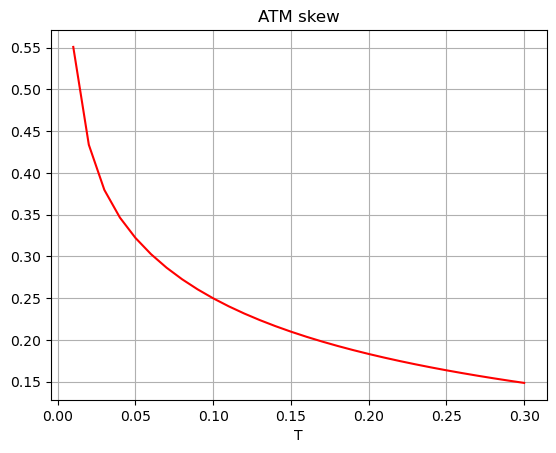

In [114]:
%%time

bump = 0.05
K_skew = np.array([1 - bump, 1 + bump]) * F0
k_skew = np.log(K_skew / F0)
T_skew = np.linspace(0.01, 0.3, 30)

option_call_skew = VanillaOption(T=T_skew, K=K_skew, flag="call")

smile_skew = option_call_skew.get_price(model=model, method="lewis", F0=F0, is_vol_surface=True, 
                                        pricing_params=LewisParams(cf_timestep=0.001, N_points=25))

atm_skew = -(np.diff(smile_skew, axis=1) / np.diff(k_skew)).squeeze()

fig, ax = plt.subplots()

ax.plot(T_skew, atm_skew, color='r')
ax.grid()
ax.set_xlabel("T")
ax.set_title("ATM skew")